In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

# Change working directory if needed
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')
    
# Load daily consumption data
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
# Load weather data (daily)
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
# Load bank holidays
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')
holiday_dates = set(uk_bank_holidays['Bank holidays'].dt.date)

Changed working directory to: c:\Users\piopi\Desktop\Projet_EI_ST4\Forecast-of-Electricity-Consumption


In [2]:
# Merge consumption and weather data on date
group_4_daily['Date'] = pd.to_datetime(group_4_daily['Date'])
weather_daily['Date'] = pd.to_datetime(weather_daily['time']).dt.date
group_4_daily['Date_only'] = group_4_daily['Date'].dt.date
df = pd.merge(group_4_daily, weather_daily, left_on='Date_only', right_on='Date', how='left')

# Add holiday feature
df['IsHoliday'] = df['Date_only'].isin(holiday_dates).astype(int)
# Add calendar features
df['DayOfWeek'] = pd.to_datetime(df['Date_x']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date_x']).dt.month
# Add lag features (previous day's consumption per Acorn group)
df = df.sort_values(['Acorn', 'Date_x'])
df['Lag1'] = df.groupby('Acorn')['Conso_kWh'].shift(1)
df['Lag7'] = df.groupby('Acorn')['Conso_kWh'].shift(7)

# Drop rows with missing values (due to lag or missing weather)
df = df.dropna(subset=['Lag1', 'Lag7', 'temperatureMax', 'temperatureMin', 'humidity', 'windSpeed'])


Acorn ACORN-C - Validation RMSE: 0.87 kWh

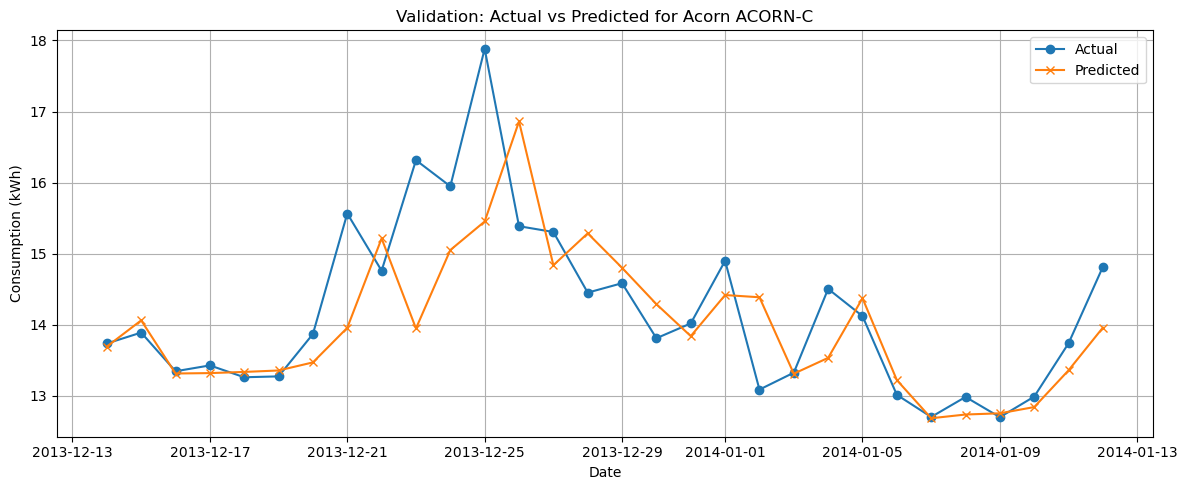

Acorn ACORN-F - Validation RMSE: 0.42 kWh


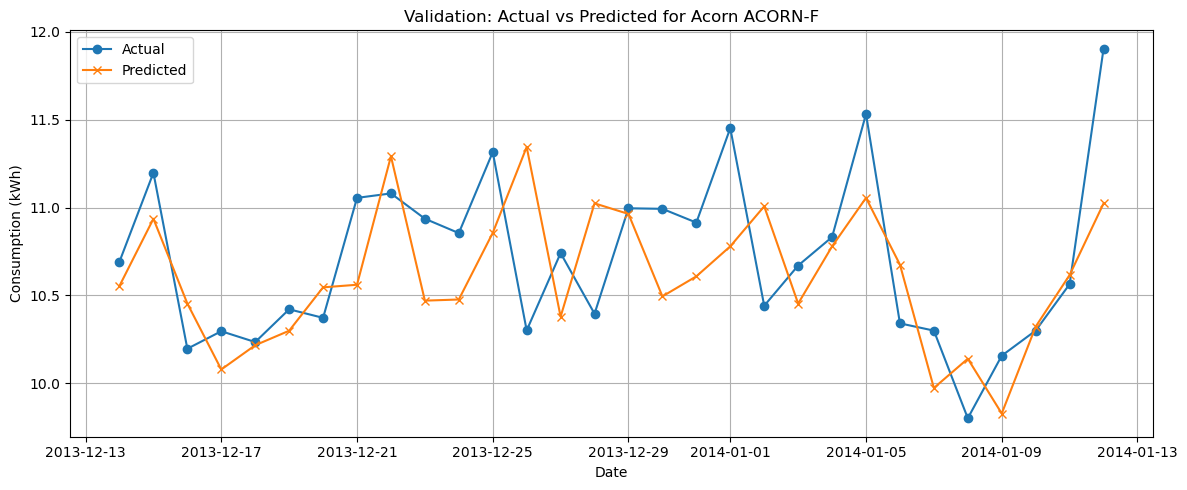

Acorn ACORN-P - Validation RMSE: 0.31 kWh


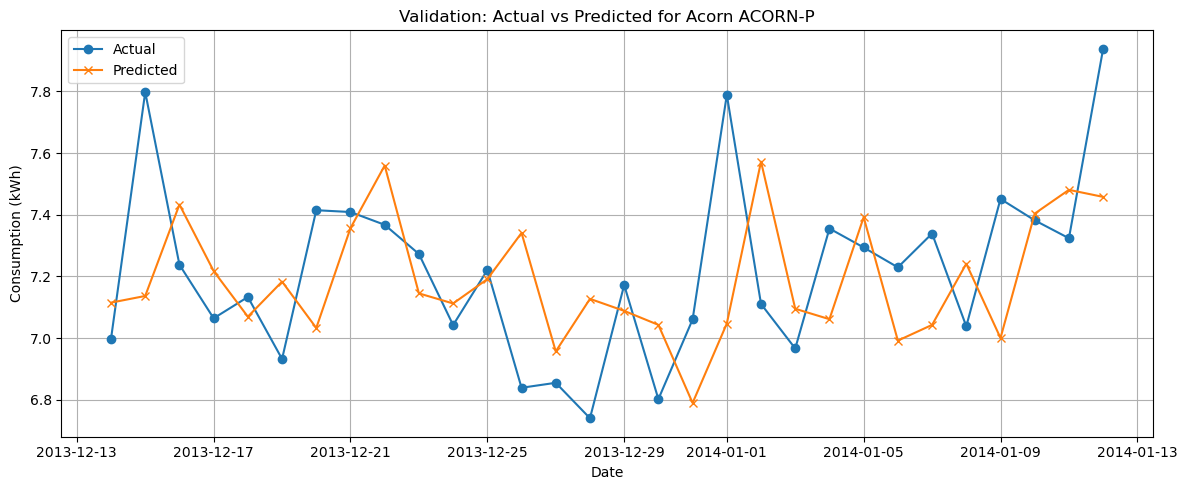

In [3]:
# Train/validation split (last 30 days for validation)
split_date = df['Date_x'].max() - pd.Timedelta(days=30)
train = df[df['Date_x'] <= split_date]
val = df[df['Date_x'] > split_date]

feature_cols = [
    'Lag1', 'Lag7', 'DayOfWeek', 'Month', 'IsHoliday',
    'temperatureMax', 'temperatureMin', 'humidity', 'windSpeed'
]
target_col = 'Conso_kWh'

# Separate model for each Acorn group
acorn_groups = df['Acorn'].unique()
results = {}

for acorn in acorn_groups:
    train_acorn = train[train['Acorn'] == acorn]
    val_acorn = val[val['Acorn'] == acorn]
    X_train = train_acorn[feature_cols]
    y_train = train_acorn[target_col]
    X_val = val_acorn[feature_cols]
    y_val = val_acorn[target_col]

    # Standardize features (important for regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)

    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    print(f"Acorn {acorn} - Validation RMSE: {val_rmse:.2f} kWh")

    # Store for later use
    results[acorn] = {
        'model': model,
        'scaler': scaler,
        'y_val': y_val,
        'y_val_pred': y_val_pred,
        'val_dates': val_acorn['Date_x']
    }

    # Plot actual vs predicted for validation
    plt.figure(figsize=(12, 5))
    plt.plot(val_acorn['Date_x'], y_val, label='Actual', marker='o')
    plt.plot(val_acorn['Date_x'], y_val_pred, label='Predicted', marker='x')
    plt.title(f'Validation: Actual vs Predicted for Acorn {acorn}')
    plt.xlabel('Date')
    plt.ylabel('Consumption (kWh)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

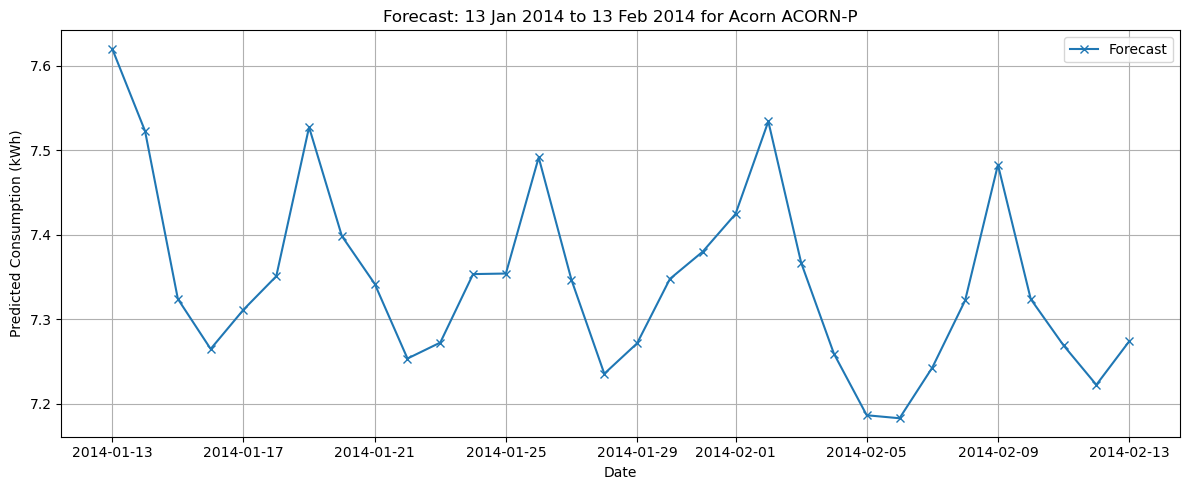

In [5]:
# Forecast for 13 Jan 2014 to 13 Feb 2014 (if weather data is available)
forecast_start = pd.Timestamp('2014-01-13')
forecast_end = pd.Timestamp('2014-02-13')
forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')

for acorn in acorn_groups:
    last_data = df[df['Acorn'] == acorn].set_index('Date_x').sort_index()
    forecast_rows = []
    # Start with last known real values
    lag_dict = {}
    for date in forecast_dates:
        # Get weather for this date
        weather_row = weather_daily[weather_daily['Date'] == date.date()]
        if weather_row.empty:
            continue
        # Lag features: use real data if available, else use previous predictions
        if date - pd.Timedelta(days=1) in last_data.index:
            lag1 = last_data.loc[date - pd.Timedelta(days=1), 'Conso_kWh']
        else:
            lag1 = lag_dict.get(date - pd.Timedelta(days=1), np.nan)
        if date - pd.Timedelta(days=7) in last_data.index:
            lag7 = last_data.loc[date - pd.Timedelta(days=7), 'Conso_kWh']
        else:
            lag7 = lag_dict.get(date - pd.Timedelta(days=7), np.nan)
        if np.isnan(lag1) or np.isnan(lag7):
            continue
        row = {
            'Lag1': lag1,
            'Lag7': lag7,
            'DayOfWeek': date.dayofweek,
            'Month': date.month,
            'IsHoliday': int(date.date() in holiday_dates),
            'temperatureMax': weather_row['temperatureMax'].values[0],
            'temperatureMin': weather_row['temperatureMin'].values[0],
            'humidity': weather_row['humidity'].values[0],
            'windSpeed': weather_row['windSpeed'].values[0],
            'Date': date
        }
        X_forecast = pd.DataFrame([row])[feature_cols]
        X_forecast_scaled = results[acorn]['scaler'].transform(X_forecast)
        y_forecast_pred = results[acorn]['model'].predict(X_forecast_scaled)[0]
        lag_dict[date] = y_forecast_pred  # Store prediction for future lags
        forecast_rows.append({**row, 'Predicted': y_forecast_pred})
    forecast_df = pd.DataFrame(forecast_rows)

    # Plot forecast
# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted'], label='Forecast', marker='x')
plt.title(f'Forecast: 13 Jan 2014 to 13 Feb 2014 for Acorn {acorn}')
plt.xlabel('Date')
plt.ylabel('Predicted Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()